<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF-285 - Computación Científica </h1>
    <h2> Linear Systems of Equations </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.20</h2>
</center>

<div id='toc' />

## Table of Contents
* [Introduction](#intro)
* [Direct Methods](#DM)
    * [LU](#lu)
    * [PALU](#palu)
    * [Cholesky](#cholesky)
* [Iterative Methods](#im)
    * [Jacobi](#jacobi)
    * [Gauss-Seidel](#gaussseidel)
    * [SOR](#sor)
* [Convergence Analysis](#ca)
* [Examples](#examples)
    * [Hilbert Matrix](#hilbertMatrix)
    * [Motivation for PALU in classnotes example](#classnotesPaluExample)
    * [Iterative Methods classnotes example](#iterativeMethodExample)
* [Exercises](#ex)
* [Acknowledgements](#acknowledgements)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu
import pandas as pd
%matplotlib inline
from scipy.linalg import hilbert

<div id='intro' />

## Introduction
[Back to TOC](#toc)

In our last Jupyter Notebook we learned how to solve 1D equations. Now, we'll go to the next level and will learn how to solve not just <i>one</i> equation, but a <i>system</i> of linear equations. This is a set of $n$ equations involving $n$ variables wherein all the equations must be satisfied at the same time. You probably know how to solve small 2D systems with methods such as substitution and reduction, but in practical real-life situations it's very likely that you'll find problems of bigger dimensions. As usual, we'll present some useful methods for solving systems of linear equations below.

<div id='DM' />

## Direct Methods
[Back to TOC](#toc)

Firstly, we will study _direct methods_. They compute the analytic solution of the system (from here comes the name **direct**) limited only by the loss of numerical precision, because of the arithmetic operations performed by the computer. Their counterpart is the _iterative methods_, which calculate an approximate solution that evolves iteratively converging to the real solution.

<div id='lu' />

### LU decomposition
[Back to TOC](#toc)

Given the matrix $A \in \mathbb{R}^{n \times n}$ square and non singular, the main goal of this method involves finding a decomposition like $A = L\,U$ where $L,U \in  \mathbb{R}^{n \times n}$ are lower and upper triangular matrices respectively.

The algorithm to perform this decomposition is basically a modified version of _Gaussian Elimination_. It basically iterates through the first $n-1$ columns, making $0$ all the entries below the main diagonal. This is accomplished by performing row operations. 

In [2]:
def lu_decomp(A, show=False, print_precision=2):
    N,_ = A.shape
    U = np.copy(A)
    L = np.identity(N)
    if show:
        print('Initial matrices')
        print('L = '); print(np.array_str(L, precision=print_precision, suppress_small=True))
        print('U = '); print(np.array_str(U, precision=print_precision, suppress_small=True))
        print('----------------------------------------')
    #iterating through columns
    for j in range(N-1):
        #iterating through rows
        for i in range(j+1,N):
            L[i,j] = U[i,j]/U[j,j]
            U[i] -= L[i,j]*U[j] 
            if show:
                print('L = '); print(np.array_str(L, precision=print_precision, suppress_small=True))
                print('U = '); print(np.array_str(U, precision=print_precision, suppress_small=True))
                print('----------------------------------------')
    return L,U

Once the decomposition is done, solving a linear system like $A\,\mathbf{x} = \mathbf{b}$ is straightforward:

$$A\,\mathbf{x} = \mathbf{b} \rightarrow L\, U\, \mathbf{x} = \mathbf{b} \ \ \text{ if we set } \ \  U\, \mathbf{x} = \mathbf{c} \rightarrow L\, \mathbf{c} = \mathbf{b} \ \ \text{ (solve for $\mathbf{c}$) } \ \rightarrow U\, \mathbf{x} = \mathbf{c}$$

and as you might know, solving lower and upper triangular systems can be easily performed by forward-substitution and backward-subsitution, respectively.

In [3]:
"""
Solves a linear system A x = b, where A is a
triangular (upper or lower) matrix
"""
def solve_triangular(A, b, upper=True):
    n = b.shape[0]
    x = np.zeros_like(b)
    if upper==True:
        #perform backward-substitution
        x[-1] = (1./A[-1,-1]) * b[-1]
        for i in range(n-2, -1, -1):
            x[i] = (1./A[i,i]) * (b[i] - np.sum(A[i,i+1:] * x[i+1:]))
    else:
        #perform forward-substitution
        x[0] = (1./A[0,0]) * b[0]
        for i in range(1,n):
            x[i] = (1./A[i,i]) * (b[i] - np.sum(A[i,:i] * x[:i]))
    return x

def solve_lu(A, b, show=False, print_precision=2):
    L,U = lu_decomp(A, show, print_precision=print_precision)
    # L.c = b with c = U.x
    c = solve_triangular(L, b, upper=False)
    x = solve_triangular(U, c)
    return x

Let's now try our implementations. We begin by creating a random $3 \times 3$ linear system:

In [4]:
A = np.random.random((3,3))
b = np.ones(3)

and then we compute the solution with our LU solver, and aditionally with the NumPy solver which computes the solution using LAPACK routines.

In [5]:
lu_sol = solve_lu(A,b, show=True)
np_sol = np.linalg.solve(A,b)

Initial matrices
L = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
U = 
[[0.84 0.95 0.8 ]
 [0.4  0.3  0.21]
 [0.61 0.53 0.44]]
----------------------------------------
L = 
[[1.   0.   0.  ]
 [0.48 1.   0.  ]
 [0.   0.   1.  ]]
U = 
[[ 0.84  0.95  0.8 ]
 [ 0.   -0.16 -0.17]
 [ 0.61  0.53  0.44]]
----------------------------------------
L = 
[[1.   0.   0.  ]
 [0.48 1.   0.  ]
 [0.72 0.   1.  ]]
U = 
[[ 0.84  0.95  0.8 ]
 [ 0.   -0.16 -0.17]
 [ 0.   -0.16 -0.13]]
----------------------------------------
L = 
[[1.   0.   0.  ]
 [0.48 1.   0.  ]
 [0.72 1.01 1.  ]]
U = 
[[ 0.84  0.95  0.8 ]
 [ 0.   -0.16 -0.17]
 [ 0.    0.    0.04]]
----------------------------------------


In order to compare these vectors, we use the Euclidean norm as follows:

In [6]:
np.linalg.norm(lu_sol - np_sol)

2.2644195468014703e-15

which is a very good result!

This method has two important facts to be noted:

1. Computing the LU decomposition requires $\sim 2\,n^3/3$ floating point operations. Can you check that?
2. When computing the LU decomposition you can see the instruction `L[i,j] = U[i,j]/U[j,j]`. Here we divide an entry below the main diagonal by the _pivot_ value. What happens if the pivot equals 0? How can we prevent that? **Answer:** PALU.

<div id='palu' />

### PALU decomposition
[Back to TOC](#toc)

As you might've noted previously, LU has a problem when a _pivot_ has the value of $0$. To handle this problem, we add row permutations to the original LU algorithm. The procedure is as follows:

1. When visiting the row $j$, search for $\max(|a_{j,j}|,\ |a_{j+1,j}|,\ \ldots,\ |a_{N-1,j}|,\ |a_{N,j}|)$ (the maximum between the pivot and the entries below it).
2. If such maximum is $|a_{j,k}| \neq |a_{j,j}|$, permutate rows $i$ and $k$ making $a_{j,k}$ the new pivot.

To keep track of all the permutations performed, we use the permutation matrix $P$. It's inicially an identity matrix which permutes its rows in the same way the algorithm does on the resulting matrix. 

In [7]:
#permutation between rows i and j on matrix A
def row_perm(A, i, j):
    tmp = np.copy(A[i])
    A[i] = A[j]
    A[j] = tmp

def palu_decomp(A, show=False, print_precision=2):
    N,_ = A.shape
    P = np.identity(N)
    L = np.zeros((N,N))
    U = np.copy(A)
    if show:
        print('Initial matrices')
        print('P = '); print(np.array_str(P, precision=print_precision, suppress_small=True))
        print('L = '); print(np.array_str(L+np.eye(N), precision=print_precision, suppress_small=True))
        print('U = '); print(np.array_str(U, precision=print_precision, suppress_small=True))
        print('----------------------------------------')
    #iterating through columns
    for j in range(N-1):
        #determine the new pivot
        p_index = np.argmax(np.abs(U[j:,j]))
        if p_index != 0:
            row_perm(P, j, j+p_index)
            row_perm(U, j, j+p_index)
            row_perm(L, j, j+p_index)
            if show:
                print('A permutation has been made')
                print('P = '); print(np.array_str(P, precision=print_precision, suppress_small=True))
                print('L = '); print(np.array_str(L+np.eye(N), precision=print_precision, suppress_small=True))
                print('U = '); print(np.array_str(U, precision=print_precision, suppress_small=True))
                print('----------------------------------------')
        #iterating through rows
        for i in range(j+1,N):
            L[i,j] = U[i,j]/U[j,j]
            U[i] -= L[i,j]*U[j]
            if show:
                print('P = '); print(np.array_str(P, precision=print_precision, suppress_small=True))
                print('L = '); print(np.array_str(L+np.eye(N), precision=print_precision, suppress_small=True))
                print('U = '); print(np.array_str(U, precision=print_precision, suppress_small=True))
                print('----------------------------------------')
    np.fill_diagonal(L,1)
    return P,L,U

The procedure to solve the system $A\,\mathbf{x}=\mathbf{b}$ remains almost the same. We have to add the efect of the permutation matrix $P$:

$$A\, \mathbf{x} = \mathbf{b} \rightarrow P\, A\, \mathbf{x} = P\, \mathbf{b} = = \widehat{\mathbf{b}} \rightarrow L\, U\, \mathbf{x} = \widehat{\mathbf{b}} \ \ \text{ if we set } \ \  U\, \mathbf{x} = \mathbf{c} \rightarrow L\, \mathbf{c} = \widehat{\mathbf{b}} \ \ \text{ (solve for $\mathbf{c}$) } \ \rightarrow U\, \mathbf{x} = \mathbf{c}$$

In [8]:
def solve_palu(A, b, show=False, print_precision=2):
    P,L,U = palu_decomp(A, show, print_precision=print_precision)
    # A.x = b -> P.A.x = P.b = b' -> L.U.x = b'
    b = np.dot(P,b)
    # L.c = b' with c = U.x
    c = solve_triangular(L, b, upper=False)
    x = solve_triangular(U, c)
    return x

Let's test this new method against the LU and NumPy solvers

In [9]:
palu_sol = solve_palu(A, b, show=True, print_precision=4)

Initial matrices
P = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
L = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
U = 
[[0.8432 0.9534 0.7996]
 [0.4046 0.2984 0.2128]
 [0.6079 0.5268 0.4424]]
----------------------------------------
P = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
L = 
[[1.     0.     0.    ]
 [0.4799 1.     0.    ]
 [0.     0.     1.    ]]
U = 
[[ 0.8432  0.9534  0.7996]
 [ 0.     -0.1592 -0.171 ]
 [ 0.6079  0.5268  0.4424]]
----------------------------------------
P = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
L = 
[[1.     0.     0.    ]
 [0.4799 1.     0.    ]
 [0.721  0.     1.    ]]
U = 
[[ 0.8432  0.9534  0.7996]
 [ 0.     -0.1592 -0.171 ]
 [ 0.     -0.1606 -0.134 ]]
----------------------------------------
A permutation has been made
P = 
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
L = 
[[1.     0.     0.    ]
 [0.721  1.     0.    ]
 [0.4799 0.     1.    ]]
U = 
[[ 0.8432  0.9534  0.7996]
 [ 0.     -0.1606 -0.134 ]
 [ 0.     -0.1592 -0.171 ]]
----------------------------------------
P = 
[[1

In [10]:
np.linalg.norm(palu_sol - lu_sol)

6.836666485528232e-15

In [11]:
np.linalg.norm(palu_sol - np_sol)

4.636427468134552e-15

In [12]:
P,L,U = palu_decomp(A)
print('P: ',P)
print('L: ',L)
print('U: ',U)

P:  [[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
L:  [[1.         0.         0.        ]
 [0.72095619 1.         0.        ]
 [0.47990691 0.99127024 1.        ]]
U:  [[ 0.84318025  0.95343162  0.7996133 ]
 [ 0.         -0.160576   -0.13404885]
 [ 0.          0.         -0.03809402]]


Here are some questions about PALU:
1. How much computational complexity has been added to the original $\sim 2n^3/3$ of LU?
2. Clearly PALU is more robust than LU, but given a non sigular matrix $A$ will it always be possible to perform the PALU decomposition?

<div id='cholesky' />

### Cholesky
[Back to TOC](#toc)

This is another direct method only applicable to _symmetric positive-definite_ matrices. In order to try this algorithm we have to create this kind of matrices. The next function generates random _symmetric positive-definite_ matrices. 

In [13]:
"""
Randomly generates an nxn symmetric positive-
definite matrix A.
"""
def generate_spd_matrix(n, flag=True):
    if flag:
        A = np.random.random((n,n))
        # Constructing symmetry
        A += A.T 
        # A = np.dot(A.T,A) # Another way
        #symmetric+diagonally dominant -> symmetric positive-definite
        deltas = 0.1*np.random.random(n)
        row_sum = A.sum(axis=1)-np.diag(A)
        np.fill_diagonal(A, row_sum+deltas)
    else:
        B = np.random.random((n,n))
        # A way to make sure the quadratic form is greater or equal to zero:
        # this means x^T*B^T\B*x >= ||B*x||, but if B is singular, it could be zero.
        A = np.dot(B.T,B)
        # To avoid a being singular, we just add a positive diagonal matrix
        A = A + np.eye(n)
    return A

Given a symmetric positive-definite matrix $A \in \mathbb{R}^{n \times n}$, the Cholesky decomposition is of the form $A =R^T R$, with $R$ being an upper triangular matrix. This method takes advantage of the properties of symmetric matrices, reaching approximately twice the efficiency of LU.

In [14]:
def cholesky_decomp(A, show=False):
    N,_ = A.shape
    A = np.copy(A)
    R = np.zeros((N,N))
    if show:
        print('Initial matrix')
        print('A = '); print(np.array_str(A, precision=2, suppress_small=True))
        print('R = '); print(np.array_str(R, precision=2, suppress_small=True))
        print('----------------------------------------')
    for i in range(N):
        R[i,i] = np.sqrt(A[i,i])
        u = (1./R[i,i])*A[i,i+1:]
        R[i,i+1:] = u
        A[i+1:,i+1:] -= np.outer(u,u)
        if show:
            print('A = '); print(np.array_str(A, precision=2, suppress_small=True))
            print('R = '); print(np.array_str(R, precision=2, suppress_small=True))
            print('----------------------------------------')
    return R

The solve stage remains the same as LU:  

In [15]:
def solve_cholesky(A, b, show=False):
    R = cholesky_decomp(A, show)
    #R^T.R.x = b -> R^T.c = b with R.x = c
    c = solve_triangular(R.T, b, upper=False)
    x = solve_triangular(R, c)
    return x

Now we test our implementation, comparing time execution with LU and PALU on two different linear systems

In [16]:
A = generate_spd_matrix(3)
b = np.ones(3)

In [17]:
b=np.array([4,2,0])
solve_cholesky(A, b, show=True)

Initial matrix
A = 
[[1.94 0.93 1.  ]
 [0.93 2.25 1.23]
 [1.   1.23 2.25]]
R = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
----------------------------------------
A = 
[[1.94 0.93 1.  ]
 [0.93 1.8  0.75]
 [1.   0.75 1.73]]
R = 
[[1.39 0.67 0.72]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
----------------------------------------
A = 
[[1.94 0.93 1.  ]
 [0.93 1.8  0.75]
 [1.   0.75 1.42]]
R = 
[[1.39 0.67 0.72]
 [0.   1.34 0.56]
 [0.   0.   0.  ]]
----------------------------------------
A = 
[[1.94 0.93 1.  ]
 [0.93 1.8  0.75]
 [1.   0.75 1.42]]
R = 
[[1.39 0.67 0.72]
 [0.   1.34 0.56]
 [0.   0.   1.19]]
----------------------------------------


array([1, 0, 0])

In [18]:
A = generate_spd_matrix(100)
b = np.ones(100)

In [19]:
%timeit solve_cholesky(A, b)
%timeit solve_lu(A, b)
%timeit solve_palu(A, b)

1.32 ms ± 4.66 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
8.26 ms ± 86.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.3 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
A = generate_spd_matrix(1000)
b = np.ones(1000)

In [21]:
%timeit solve_cholesky(A, b)
%timeit solve_lu(A, b)
%timeit solve_palu(A, b)

538 ms ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.07 s ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.17 s ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<div id='im' />

## Iterative Methods
[Back to TOC](#toc)

In [22]:
"""
Randomly generates an nxn strictly diagonally 
dominant matrix A.
"""
def generate_dd_matrix(n):
    A = np.random.random((n,n))
    deltas = 0.1*np.random.random(n)
    row_sum = A.sum(axis=1)-np.diag(A)
    np.fill_diagonal(A, row_sum+deltas)
    return A

"""
Computes relative error between each row on 
X matrix and y vector. 
"""
def error(X, y):
    D = X-y
    err = np.linalg.norm(D, axis=1, ord=np.inf)
    return err

As before we will create a linear system $A x = b$, with $A$ as a diagonally dominant matrix, which is a **sufficient** condition for the methods we will study in this section converge 

In [23]:
A = np.array([[3, -1, 0, 0, 0, 0.5],[-1, 3, -1, 0, 0.5, 0],[0, -1, 3, -1, 0, 0],[0, 0, -1, 3, -1, 0],
              [0, 0.5, 0, -1, 3, -1],[0.5, 0, 0, 0, -1, 3]])
b = np.array([2.5, 1.5, 1., 1., 1.5, 2.5])
print ('A='); print (A)
print ('b='); print (b)

A=
[[ 3.  -1.   0.   0.   0.   0.5]
 [-1.   3.  -1.   0.   0.5  0. ]
 [ 0.  -1.   3.  -1.   0.   0. ]
 [ 0.   0.  -1.   3.  -1.   0. ]
 [ 0.   0.5  0.  -1.   3.  -1. ]
 [ 0.5  0.   0.   0.  -1.   3. ]]
b=
[2.5 1.5 1.  1.  1.5 2.5]


and find the solution $x$ through `np.linalg.solve` to use it as the reference solution-

In [24]:
np_sol = np.linalg.solve(A,b)

<div id='jacobi' />

### Jacobi
[Back to TOC](#toc)

In [25]:
"""
Iterative methods implementations returns an array X
with the the solutions at each iteration
"""
def jacobi(A, b, n_iter=50):
    n = A.shape[0]
    #array with solutions
    X = np.empty((n_iter, n))
    #initial guess
    X[0] = np.zeros(n)
    #submatrices
    D = np.diag(A)
    Dinv = D**-1
    R = A - np.diag(D) # R = (L+U)
    for i in range(1, n_iter):
        # X[i] = Dinv*(b - np.dot(R, X[i-1]))
        # v1.12
        ri = b - np.dot(A, X[i-1])
        X[i] = X[i-1]+Dinv*ri # = np.dot(np.linalg.inv(D),ri)
    return X
def jacobi_M(A):
    L = np.tril(A,-1)
    U = np.triu(A,1)
    D = np.diag(np.diag(A))
    M = -np.dot(np.linalg.inv(D),L+U)
    return M

$\mathbf{x}_{n+1}=M\,\mathbf{x}_{n}+\widehat{\mathbf{b}}$

Now let's resolve the same linear system with Jacobi method!

In [26]:
jac_sol = jacobi(A,b, n_iter=50)

In [27]:
jac_err = error(jac_sol, np_sol)
it = np.linspace(1, 50, 50)

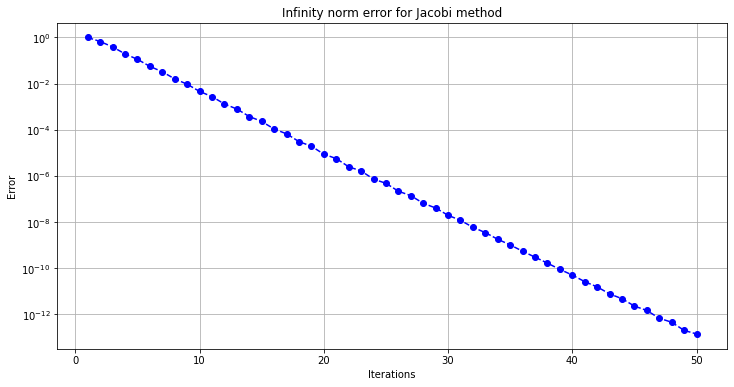

In [28]:
plt.figure(figsize=(12,6))
plt.semilogy(it, jac_err, marker='o', linestyle='--', color='b')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Infinity norm error for Jacobi method')
plt.show()

In [29]:
Mj = jacobi_M(A)
print(np.linalg.norm(Mj))

1.1055415967851334


In [30]:
np.linalg.eigvals(Mj)

array([-0.56734117, -0.53694624, -0.03039493,  0.03039493,  0.56734117,
        0.53694624])

In [31]:
np.abs(np.linalg.eigvals(Mj))

array([0.56734117, 0.53694624, 0.03039493, 0.03039493, 0.56734117,
       0.53694624])

In [32]:
np.max(np.abs(np.linalg.eigvals(Mj)))

0.5673411660774048

<div id='gaussseidel' />

### Gauss Seidel
[Back to TOC](#toc)

In [33]:
def gauss_seidel(A, b, n_iter=50):
    n = A.shape[0]
    #array with solutions
    X = np.empty((n_iter, n))
    #initial guess
    X[0] = np.zeros(n)
    #submatrices
    R = np.tril(A) # R=(L+D)
    U = A-R
    for i in range(1, n_iter):
        #X[i] = solve_triangular(R, b-np.dot(U, X[i-1]), upper=False)
        # v1.11
        X[i] = X[i-1]+solve_triangular(R, b-np.dot(A, X[i-1]), upper=False)
    return X
def gauss_seidel_M(A):
    L = np.tril(A,-1)
    U = np.triu(A,1)
    D = np.diag(np.diag(A))
    M = -np.dot(np.linalg.inv(L+D),U)
    return M

Now let's resolve the same linear system with Gauss-Seidel method!

In [34]:
gauss_seidel_sol = gauss_seidel(A,b)

In [35]:
gauss_seidel_err = error(gauss_seidel_sol, np_sol)

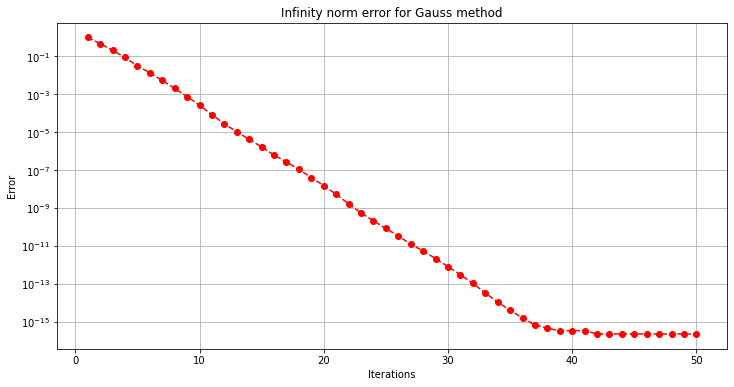

In [36]:
plt.figure(figsize=(12,6))
plt.semilogy(it, gauss_seidel_err, marker='o', linestyle='--', color='r')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Infinity norm error for Gauss method')
plt.show()

Here are some questions about Gauss-Seidel:
- Can you explain what the differences between this and Jacobi method are?
- Why do we use `solve_triangular` instead of `np.linalg.solve` or something similar?

In [37]:
Mgs = gauss_seidel_M(A)
print(np.linalg.norm(Mgs))

0.8351230731594124


In [38]:
np.max(np.abs(np.linalg.eigvals(Mgs)))

0.3737279987723841

<div id='sor' />

### SOR
[Back to TOC](#toc)

In [39]:
def sor(A, b, w=1.05, n_iter=50):
    n = A.shape[0]
    #array with solutions
    X = np.empty((n_iter, n))
    #initial guess
    X[0] = np.zeros(n)
    #submatrices
    R = np.tril(A) #R=(L+D)
    U = A-R
    # v1.11
    L = np.tril(A,-1)
    D = np.diag(np.diag(A))
    M = L+D/w
    for i in range(1, n_iter):
        #X_i = solve_triangular(R, b-np.dot(U, X[i-1]), upper=False)
        #X[i] = w*X_i + (1-w)*X[i-1]
        # v1.11
        X[i] = X[i-1]+solve_triangular(M, b-np.dot(A, X[i-1]), upper=False)
    return X
def sor_M(A,w=1.05):
    L = np.tril(A,-1)
    U = np.triu(A,1)
    D = np.diag(np.diag(A))
    M = np.dot(np.linalg.inv(w*L + D),((1-w)*D -w*U))
    return M

Now let's resolve the same linear system with Jacobi method!

In [40]:
sor_sol = sor(A, b, w=1.15)

In [41]:
sor_err = error(sor_sol, np_sol)

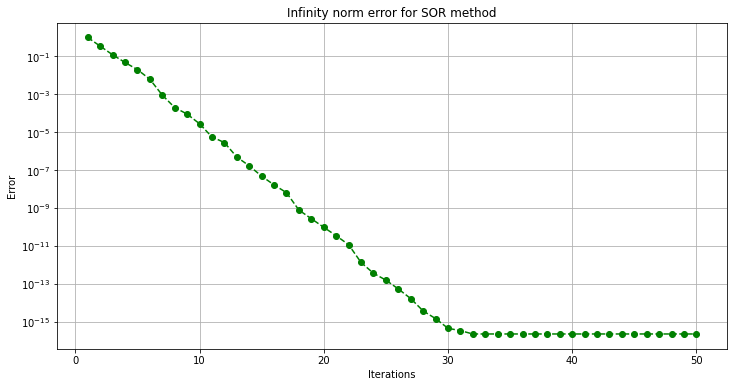

In [42]:
plt.figure(figsize=(12,6))
plt.semilogy(it, sor_err, marker='o', linestyle='--', color='g')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Infinity norm error for SOR method')
plt.show()

In [43]:
Msor = sor_M(A)
print(np.linalg.norm(Msor))

0.850053072081257


In [44]:
np.max(np.abs(np.linalg.eigvals(Msor)))

0.3343477054811493

How can we choose a good value of $\omega$? Well there are  some methods you could search, but for now we will try a naive way, i.e, computing the solution for a range $\omega \in [1,1.3]$ as follows:

In [45]:
n = 30 #width of subdivisions
sor_solutions = list()
for w in np.linspace(1., 1.3, n):
    sor_solutions.append(sor(A, b, w, n_iter=5)[-1])
np.asarray(sor_solutions)

#now compute error solutions with each w
sor_errors = error(sor_solutions, np_sol)
w = np.linspace(1., 1.3, n)

as you can see, we compute the SOR solution with 5 iterations for each $\omega$ on the given range. 

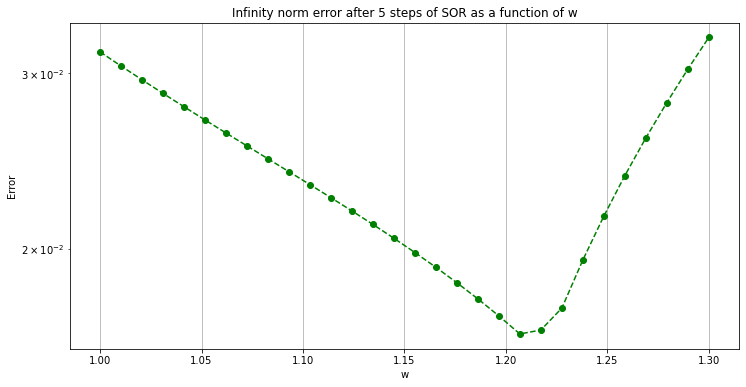

In [46]:
plt.figure(figsize=(12,6))
plt.semilogy(w, sor_errors, marker='o', linestyle='--', color='g')
plt.grid(True)
plt.xlabel('w')
plt.ylabel('Error')
plt.title('Infinity norm error after 5 steps of SOR as a function of w')
plt.show()

Here are some questions about SOR:
- Why can averaging the current solution with the Gauss-Seidel solution improve convergence?
- Why do we use $\omega > 1$ and not $\omega < 1$?
- Could you describe a method to find the best value of $\omega$ (the one which optimizes convergence)?
- Would it be a better option to re-compute $\omega$ at each iteration?

<div id='ca' />

## Convergence Analysis
[Back to TOC](#toc)

Let's see convergence plots all together

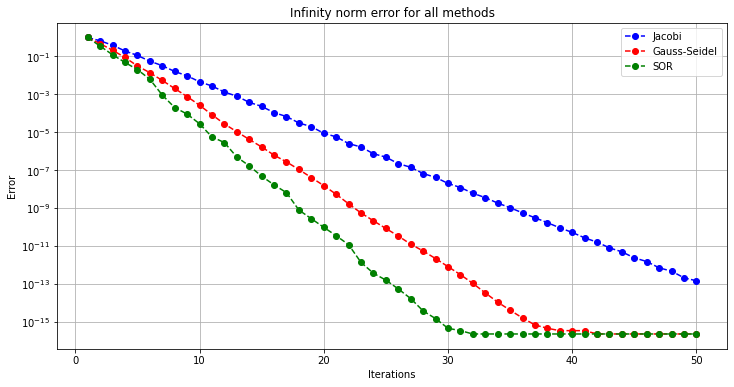

In [47]:
plt.figure(figsize=(12,6))
plt.semilogy(it, jac_err, marker='o', linestyle='--', color='b', label='Jacobi')
plt.semilogy(it, gauss_seidel_err, marker='o', linestyle='--', color='r', label='Gauss-Seidel')
plt.semilogy(it, sor_err, marker='o', linestyle='--', color='g', label='SOR')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Infinity norm error for all methods')
plt.legend(loc=0)
plt.show()

<div id='examples' />

## Examples
[Back to TOC](#toc)

<div id='hilbertMatrix' />

### Hilbert Matrix
[Back to TOC](#toc)

In [48]:
N=20
F_errors=np.zeros(N+1)
B_errors=np.zeros(N+1)
kappas=np.zeros(N+1)
my_range=np.arange(5,N+1)
for n in my_range:
    A=hilbert(n)
    x_exact=np.ones(n)
    b=np.dot(A,x_exact)
    x=np.linalg.solve(A,b)
    F_errors[n]=np.linalg.norm(x-x_exact)/np.linalg.norm(x_exact)
    kappas[n]=np.linalg.cond(A,2)
    B_errors[n]=np.linalg.norm(b-A @ x)/np.linalg.norm(b)

<Figure size 360x720 with 0 Axes>

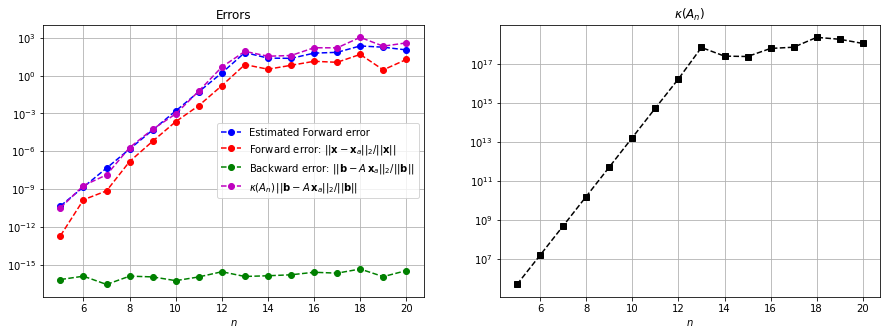

In [49]:
plt.figure(figsize=(5,10))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey = False)

ax1.semilogy(my_range, 10.**(-16+np.log10(kappas[my_range])), marker='o', linestyle='--', color='b',label='Estimated Forward error')
ax1.semilogy(my_range, F_errors[my_range], marker='o', linestyle='--', color='r',label=r'Forward error: $||\mathbf{x}-\mathbf{x}_a||_2/||\mathbf{x}||$')
ax1.semilogy(my_range, B_errors[my_range], marker='o', linestyle='--', color='g',label=r'Backward error: $||\mathbf{b}-A\,\mathbf{x}_a||_2/||\mathbf{b}||$')
ax1.semilogy(my_range, kappas[my_range]*B_errors[my_range], marker='o', linestyle='--', color='m', label=r'$\kappa(A_n)\,||\mathbf{b}-A\,\mathbf{x}_a||_2/||\mathbf{b}||$')
ax1.set_title('Errors')
ax1.grid(True)
ax1.set_xlabel('$n$')
ax1.legend(loc='best')

ax2.semilogy(my_range, kappas[my_range], marker='s', linestyle='--', color='k',label=r'$\kappa(A_n)$')
ax2.set_title(r'$\kappa(A_n)$')
ax2.set_xlabel('$n$')
ax2.grid(True)
plt.show()

Recall:

$\dfrac{1}{\kappa(A)}\dfrac{\|\mathbf{b}-A\,\mathbf{x}_a\|}{\|\mathbf{b}\|} \leq \dfrac{\|\mathbf{x}-\mathbf{x}_a\|}{\|\mathbf{x}\|} \leq \kappa(A)\,\dfrac{\|\mathbf{b}-A\,\mathbf{x}_a\|}{\|\mathbf{b}\|}$

Let's solve a linear system of equations with $H_{200}$:

In [50]:
n = 200
# Generating matrix
A = hilbert(n)
# Defining the 'exact' solution
x_exact = np.ones(n)
# If we know the exact solution, we can compute the RHS just by multiplying 'A' by 'x_exact'
b = A @ x_exact
# Using the NumPy routine to solve the linear system of equations.
x = np.linalg.solve(A,b) # A.x = A.1 = b

Now, we compute the condition number of $A=H_{200}$

In [51]:
kappa=np.linalg.cond(A,2)
print(np.log10(kappa))

19.764121443009643


We compute the Backward error, which is small.

In [52]:
np.linalg.norm(b-np.dot(A,x))

1.2485246495844636e-13

We now compute the Forward error. This is only possible since we know the exact solution by construction.

In [53]:
np.linalg.norm(x-x_exact)

3177.2609667213096

In [54]:
comparing_solutions=np.zeros((n,2))
comparing_solutions[:,0]=x_exact
comparing_solutions[:,1]=x
df=pd.DataFrame(comparing_solutions, columns=["Exact solution", "Numerical solution"])
df.style.set_caption("Comparison between the exact solution and the NumPy-solve's solution")

,Exact solution,Numerical solution
0,1.000000,0.999992
1,1.000000,1.001246
2,1.000000,0.949971
3,1.000000,1.845583
4,1.000000,-6.287111
5,1.000000,34.747531
6,1.000000,-73.621575
7,1.000000,0.150513
8,1.000000,392.388008
9,1.000000,-805.924387


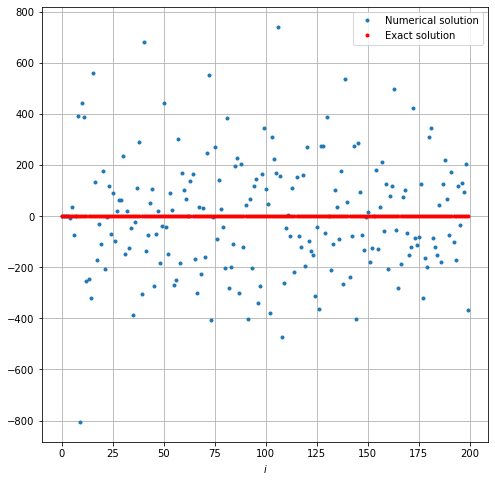

In [55]:
plt.figure(figsize=(8,8))
plt.plot(x,'.',label='Numerical solution')
plt.plot(x_exact,'r.', label='Exact solution')
plt.grid(True)
plt.xlabel('$i$')
plt.legend(loc='best')
plt.show()

<div id='classnotesPaluExample' />

### Motivation for PALU in classnotes example
[Back to TOC](#toc)

In [56]:
A=np.array([[1e-20, 1],[1,2]])

In [57]:
l,u=lu_decomp(A, show=True)

Initial matrices
L = 
[[1. 0.]
 [0. 1.]]
U = 
[[0. 1.]
 [1. 2.]]
----------------------------------------
L = 
[[1.e+00 0.e+00]
 [1.e+20 1.e+00]]
U = 
[[ 1.e-20  1.e+00]
 [ 0.e+00 -1.e+20]]
----------------------------------------


In [58]:
np.dot(l,u)

array([[1.e-20, 1.e+00],
       [1.e+00, 0.e+00]])

In [59]:
p,l,u=palu_decomp(A, show=True)

Initial matrices
P = 
[[1. 0.]
 [0. 1.]]
L = 
[[1. 0.]
 [0. 1.]]
U = 
[[0. 1.]
 [1. 2.]]
----------------------------------------
A permutation has been made
P = 
[[0. 1.]
 [1. 0.]]
L = 
[[1. 0.]
 [0. 1.]]
U = 
[[1. 2.]
 [0. 1.]]
----------------------------------------
P = 
[[0. 1.]
 [1. 0.]]
L = 
[[1. 0.]
 [0. 1.]]
U = 
[[1. 2.]
 [0. 1.]]
----------------------------------------


<div id='iterativeMethodExample' />

### Iterative Methods classnotes example
[Back to TOC](#toc)

In [60]:
A=np.array([[5.,4.],[1.,3.]])
b=np.array([6.,-1.])
np_sol = np.linalg.solve(A,b)

In [61]:
jac_sol = jacobi(A, b, n_iter=50)
jac_err = error(jac_sol, np_sol)

In [62]:
gauss_seidel_sol = gauss_seidel(A, b, n_iter=50)
gauss_seidel_err = error(gauss_seidel_sol, np_sol)

In [63]:
sor_sol = sor(A, b, w=1.09310345, n_iter=50)
sor_err = error(sor_sol, np_sol)

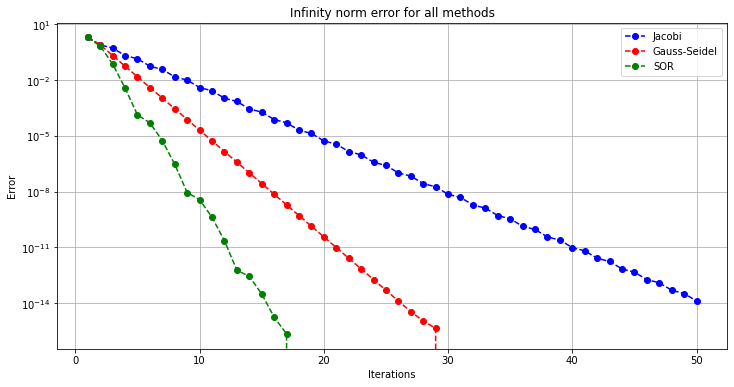

In [64]:
plt.figure(figsize=(12,6))
plt.semilogy(it, jac_err, marker='o', linestyle='--', color='b', label='Jacobi')
plt.semilogy(it, gauss_seidel_err, marker='o', linestyle='--', color='r', label='Gauss-Seidel')
plt.semilogy(it, sor_err, marker='o', linestyle='--', color='g', label='SOR')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Infinity norm error for all methods')
plt.legend(loc=0)
plt.show()

In [65]:
log10_errors=np.zeros((50,3))
log10_errors[:,0]=jac_err
log10_errors[:,1]=gauss_seidel_err
log10_errors[:,2]=sor_err
log10_errors=np.log10(log10_errors[:10,:])
#np.shape(log10_errors)
df=pd.DataFrame(log10_errors, columns=["Jacobi", "Gauss-Seidel","SOR($\omega$)"])
df.style.set_caption("Log10 of error for each method indicated")

,Jacobi,Gauss-Seidel,SOR($\omega$)
0,0.301030,0.301030,0.301030
1,-0.096910,-0.096910,-0.162237
2,-0.273001,-0.670941,-1.131888
3,-0.670941,-1.244973,-2.419283
4,-0.847033,-1.819004,-3.868075
5,-1.244973,-2.393035,-4.292827
6,-1.421064,-2.967066,-5.253905
7,-1.819004,-3.541098,-6.528202
8,-1.995095,-4.115129,-8.042639
9,-2.393035,-4.689160,-8.423748


<div id='ex' />

## Exercises
[Back to TOC](#toc)

Now that you know how to solve systems of linear equations problem with these methods, let's try to answer a few questions!

$a)$ Find the values of $\alpha$ that make possible to do a LU descomposition of the following matrix:

$$ \begin{bmatrix}
   \alpha & 2  \\[0.3em]
   1 & \alpha  \end{bmatrix} $$

$b)$- Let $A$ be the following matrix:

$$ A = \begin{bmatrix}
        2 &  4 &  2  \\[0.3em]
       -1 &  1 &  2  \\[0.3em]
       -1 & -3 & -1  \end{bmatrix} $$ 
       
   - Find the PALU descomposition of the matrix $A$.
   
   - Solve the system of equations $Ax = \left[1 , \frac{1}{2}, \frac{1}{3}\right]^T$.

$c)$ Considering this matrix:

$$  \begin{bmatrix}
    1 & 1 & 0  \\[0.3em]
    1 & 5 & 2  \\[0.3em]
    0 & 2 & 3  \end{bmatrix} $$
       
   - Find the LU descomposition.
    
   - Find the Cholesky descomposition.
    
   - Compare the efficiency of both methods.

$d)$ Use Jacobi, Gauss Seidel, and SOR to solve the following system of equations (number of iterations = 2):

$$2x + y = 3$$
$$x + 2y = 2$$

   - Which is the best method to solve this problem (with better results)?

$e)$ Explain the pros and cons of using iterative methods instead of the direct ones.



<div id='acknowledgements' />

# Acknowledgements
[Back to TOC](#toc)
* _Material created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _and assistants: Laura Bermeo, Alvaro Salinas, Axel Simonsen and Martín Villanueva. DI UTFSM. April 2016._
* _Update May 2020 - v1.11 - C.Torres_ : Fixing formatting issues.
* _Update May 2021 - v1.13 - C.Torres_ : Adding link to toc, formatting and addind the 'precision' parameter to lu_decomp, palu_decom, solve_lu, and solve_palu.
* _Update May 2021 - v1.14 - C.Torres_ : Adding classnotes examples and changing 'precision' by 'print_precision' to avoid confusion. Notice that 'print_precision' only defines the number of decimals showed when printing certain outputs values.
* _Update May 2021 - v1.15 - C.Torres_ : Modifying L in 'palu_decomp' so it shows 1's in the diagonal from the beginning in the computation.
* _Update October 2021 - v1.16 - C.Torres_ : Moving pandas library import to the top cell.
* _Update October 2021 - v1.17 - C.Torres_ : Improving Hilbert matrix example.
* _Update October 2021 - v1.18 - C.Torres_ : Fixing normalization coefficient in Hilbert matrix example.
* _Update April 2022 - v1.19 - C.Torres_ : Fixing syntax.
* _Update November 2022 - v1.20 - A. Carvajal_ : Fixing typo. 